
# Cole-Cole

The Cole-Cole model (CCM, Cole \& Cole 1941), written in terms of conductivities instead of electric permittivities as by the original authors, is given by

$$
    \sigma(\omega) = \sigma_\infty + \frac{\sigma_0 - \sigma_\infty}{1 + (\rm{i}\omega\tau)^c}\ ,
$$

where $\sigma_0$ and $\sigma_\infty$ refer to the low-frequency and high-frequency conductivity values, respectively, $\tau$ is the central relaxation time, and $c$ the CCM exponent describing the broadness of the
relaxation time distribution.



**References**

- **Cole, K.S., and R.H. Cole, 1941**, Dispersion and adsorption in
  dielectrics. I. Alternating current characteristics; *Journal of Chemical
  Physics*, Volume 9, Pages 341-351, doi:
  [10.1063/1.1750906](https://doi.org/10.1063/1.1750906).

In [1]:
import emg3d
import empymod
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, InsetPosition, mark_inset

In [2]:
%matplotlib notebook

## Cole-Cole Model

In [3]:
def cole_cole(inp, p_dict):
    """Cole-Cole Model (1941)."""

    # Compute complex conductivity from Cole-Cole
    iotc = np.outer(2j*np.pi*p_dict['freq'], inp['tau'])**inp['c']
    condH = inp['cond_8'] + (inp['cond_0']-inp['cond_8'])/(1+iotc)
    condV = condH/p_dict['aniso']**2

    # Add electric permittivity contribution
    etaH = condH + 1j*p_dict['etaH'].imag
    etaV = condV + 1j*p_dict['etaV'].imag

    return etaH, etaV

## Model and survey parameters

In [4]:
# Frequencies and times
frequencies = np.logspace(-9, 2, 501)
times = np.logspace(np.log10(0.03), 1, 301)

# Model parameters for frequency-domain and time-domain computation
off = 900
model = {
    'src': (-50, 50, 0, 0, 0.01, 0.01),
    'rec': (off, 0, 0.01, 0, 0),
    'depth': [0, 300, 400],
    'verb': 1
}

# Model parameters for frequency-domain computation
fmod = {'freqtime': frequencies}

# Model parameters for time-domain computation
tmod = {'freqtime': times, 'signal': -1}

# Conductivities for Cole-Cole model;
# Only the third layer shows IP effects
cond_0 = np.array([5e-15, 1, 1, 1])
cond_8 = np.array([5e-15, 1, 1.25, 1])
m_param = (cond_8 - cond_0)/cond_8
c_vals = [0.25, 0.5, 0.75, 1.0]

# Collect Cole-Cole model parameters
cole_model = {'res': 1/cond_0, 'cond_0': cond_0, 'cond_8': cond_8,
              'tau': [0, 0, 1, 0], 'func_eta': cole_cole}

# Create a Fourier instance
Fourier = emg3d.utils.Fourier(
    time=times,
    fmin=1e-8,
    fmax=1e1,
    signal=tmod['signal'],
    every_x_freq=5,
    ft='dlf',
    ftarg={'dlf': 'key_201_CosSin_2012', 'kind': 'cos', 'pts_per_dec': -1},
)

# Model parameters for reduced frequency-domain computation
rmod = {'freqtime': Fourier.freq_calc}

   time        [s] :  0.03 - 10 : 301  [min-max; #]
   Fourier         :  DLF (Cosine-Filter)
     > Filter      :  Key 201 CosSin (2012)
     > DLF type    :  Lagged Convolution
   Req. freq  [Hz] :  1.4626E-08 - 6.82797E+06 : 244  [min-max; #]
   Calc. freq [Hz] :  1.4626E-08 - 8.28576 : 30  [min-max; #]


## Computation

In [5]:
# Compute responses without IP
freq_noip = empymod.bipole(res=1/cond_0, **model, **fmod)
time_noip = empymod.bipole(res=1/cond_0, **model, **tmod)

def comp_reduced(res):
    return Fourier.freq2time(empymod.bipole(res=res, **model, **rmod), off)

ft_noip = comp_reduced(1/cond_0)

fcole, tcole, ftcole, error = {}, {}, {}, {}
for i, c in enumerate(c_vals):
    cole_model['c'] = [0, 0, c, 0]
    
    fcole[c] = empymod.bipole(res=cole_model, **model, **fmod)
    tcole[c] = empymod.bipole(res=cole_model, **model, **tmod)
    ftcole[c] = comp_reduced(cole_model)
    error[c] = 100*abs((ftcole[c]-tcole[c])/tcole[c])

<IPython.core.display.Javascript object>


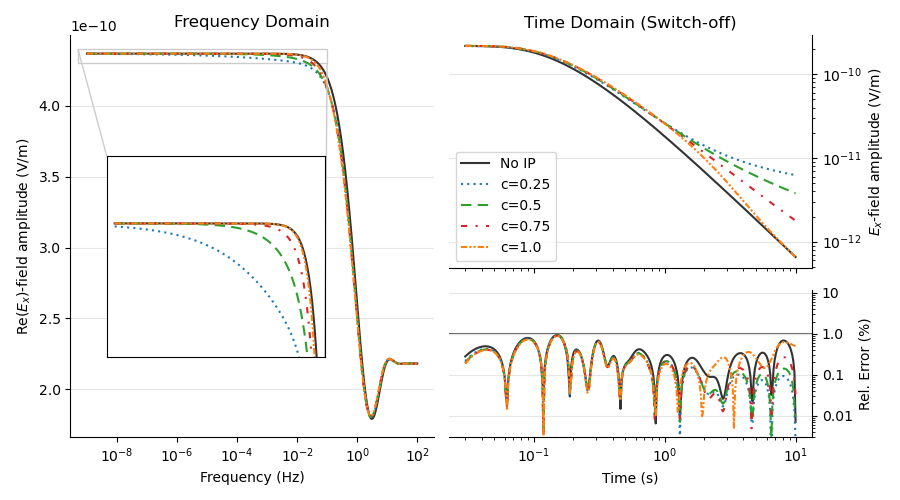

<ipython-input-6-913d6a13d580>:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


In [6]:
# Start figure
fig = plt.figure(figsize=(9, 5))
ax1 = plt.subplot2grid((5, 2), (0, 0), rowspan=5)
ax2 = plt.subplot2grid((5, 2), (0, 1), rowspan=3)
ax3 = plt.subplot2grid((5, 2), (3, 1), rowspan=2)

# Create inset plot
ax4 = plt.axes([0,0,1,1])
ax4.set_axes_locator(InsetPosition(ax1, [0.1, 0.2, 0.6, 0.5]))

# Plot No-IP data
ax1.set_title('Frequency Domain')
ax1.plot(frequencies, freq_noip.real, '0.2', label='No IP')
ax4.plot(frequencies, freq_noip.real, '0.2')
ax2.set_title('Time Domain (Switch-off)')
ax2.plot(times, time_noip, '0.2', label='No IP')
ax3.plot(times, 100*abs((ft_noip-time_noip)/time_noip), '0.2')

# Plot IP data
ds = [(1, 2), (5, 3), (3, 4, 1, 4), (3, 1, 1, 1, 1, 1)]
cl = ['C0', 'C2', 'C3', 'C1']
for i, c in enumerate(c_vals):
    ax1.plot(frequencies, fcole[c].real, f'{cl[i]}', dashes=ds[i])
    ax4.plot(frequencies, fcole[c].real, f'{cl[i]}', dashes=ds[i])
    ax2.plot(times, tcole[c], f'{cl[i]}', dashes=ds[i], label=f"c={c}")
    #ax2.plot(times, ftcole[c], f'w', dashes=[1, 8])
    ax3.plot(times, error[c], f'{cl[i]}', dashes=ds[i])

# Settings f-domain
ax1.set_xscale('log')
#ax1.set_yscale('log')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Re($E_x$)-field amplitude (V/m)')
ax1.grid(axis='y', c='0.9')

# Settings t-domain
ax2.legend()
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_ylabel('$E_x$-field amplitude (V/m)')
ax2.set_xticklabels([])
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.grid(axis='y', c='0.9')

# Settings error
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel('Time (s)')
ax3.axhline(1, color='.4', zorder=1)
ax3.set_ylabel('Rel. Error (%)')
ax3.set_ylim([3e-3, 12])
ax3.set_yticks([0.01, 0.1, 1, 10])
ax3.set_yticklabels(['0.01', '0.1', '1.0', '10'])
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.grid(axis='y', c='0.9')

# Setting inset plot
ax4.set_xscale('log')
#ax4.set_yscale('log')
ax4.set_xlim([5e-10, 1e-1])  
ax4.set_ylim([4.3e-10, 4.4e-10])  
ax4.set_xticks([])
ax4.set_yticks([])
mark_inset(ax1, ax4, loc1=2, loc2=4, fc="none", ec='0.8')

# Switch off spines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.spines['left'].set_visible(False)

# fig.suptitle(f"m = {np.round(m_param[2], 3)}")

fig.tight_layout()
plt.savefig('../figures/11-cole-cole-model.pdf', bbox_inches='tight')
fig.show()

In [7]:
empymod.Report()

--------------------------------------------------------------------------------
  Date: Fri Feb 26 16:55:11 2021 CET

                OS : Linux
            CPU(s) : 4
           Machine : x86_64
      Architecture : 64bit
               RAM : 15.5 GB
       Environment : Jupyter

  Python 3.8.6 | packaged by conda-forge | (default, Dec 26 2020, 05:05:16)
  [GCC 9.3.0]

             numpy : 1.19.5
             scipy : 1.6.0
             numba : 0.51.2
           empymod : 2.0.4
           IPython : 7.19.0
        matplotlib : 3.3.3

  Intel(R) Math Kernel Library Version 2020.0.1 Product Build 20200208 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------